# TCN–LGBM Ensemble ETH/USDT

## 1. Inisialisasi & Konfigurasi

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from tensorflow.keras import layers
import joblib
from sklearn.preprocessing import StandardScaler


plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True

class CONFIG:
    symbol = "ETH/USDT"
    timeframe = "1h"
    start = "2021-01-01"
    end = None
    seq_len = 168 # past hours (7 days)
    horizon = 1          # 1-step ahead per candle
    train_ratio = 0.7
    val_ratio = 0.15
    tcn_epochs = 50
    tcn_batch = 32


## 2. Pengambilan Data OHLCV

In [5]:
def fetch_ohlcv_ccxt(symbol, timeframe, start=None, end=None, limit=1000):
    ex = ccxt.binance()
    since = ex.parse8601(start + "T00:00:00Z") if start else None
    end_ts = ex.parse8601(end + "T00:00:00Z") if end else None

    all_rows = []
    while True:
        batch = ex.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not batch:
            break

        all_rows.extend(batch)
        last_ts = batch[-1][0]

        # update since untuk next loop
        since = last_ts + 1

        # kalau pakai end, berhenti kalau sudah lewat
        if end_ts is not None and last_ts >= end_ts:
            break

        # kalau batch kurang dari limit, artinya sudah mentok data
        if len(batch) < limit:
            break

    df = pd.DataFrame(all_rows, columns=["timestamp","open","high","low","close","volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df = df.set_index("timestamp").sort_index()
    return df


In [6]:
df = fetch_ohlcv_ccxt(CONFIG.symbol, CONFIG.timeframe, CONFIG.start, CONFIG.end)
print(df.head())
print(df.tail())
print("Total rows:", len(df))
df.to_csv("eth_usdt_1h_2021.csv")


                       open    high     low   close       volume
timestamp                                                       
2021-01-01 00:00:00  736.42  739.00  729.33  734.07  27932.69884
2021-01-01 01:00:00  734.08  749.00  733.37  748.28  52336.18779
2021-01-01 02:00:00  748.27  749.00  742.27  744.06  33019.50100
2021-01-01 03:00:00  744.06  747.23  743.10  744.82  17604.80859
2021-01-01 04:00:00  744.87  747.09  739.30  742.29  18794.15424
                        open     high      low    close      volume
timestamp                                                          
2025-11-15 09:00:00  3143.49  3165.51  3138.88  3152.99  11574.2770
2025-11-15 10:00:00  3152.99  3171.52  3145.33  3169.00   7392.7213
2025-11-15 11:00:00  3169.00  3172.19  3146.66  3152.52   6509.5023
2025-11-15 12:00:00  3152.52  3168.00  3147.37  3162.27   6604.8458
2025-11-15 13:00:00  3162.27  3171.78  3159.10  3170.07   2241.1112
Total rows: 42696


## 3. Pembentukan Fitur & Dataset Supervised

In [7]:
def make_supervised_tabular(df, seq_len, horizon):
    data = df.copy()
    data["return"] = data["close"].pct_change() # menghitung return (persentase perubahan harga)
    data = data.dropna()

    X_list, y_list, idx_list = [], [], []

    values = data[["open","high","low","close","volume","return"]].values
    closes = data["close"].values
    index = data.index

    for i in range(seq_len, len(data) - horizon + 1):
        X_list.append(values[i-seq_len:i, :].reshape(-1))
        y_list.append(closes[i + horizon - 1])
        idx_list.append(index[i + horizon - 1])

    return np.array(X_list), np.array(y_list), np.array(idx_list)


def make_supervised_sequence(df, seq_len, horizon):
    data = df.copy()
    data["return"] = data["close"].pct_change() # menghitung return (persentase perubahan harga)
    data = data.dropna()

    # Target: tetap pakai CLOSE asli (tidak dinormalisasi)
    closes = data["close"].values
    index = data.index

    # Fitur yang dinormalisasi untuk TCN
    feat_cols = ["open", "high", "low", "close", "volume", "return"]
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(data[feat_cols])

    X_list, y_list, idx_list = [], [], []

    for i in range(seq_len, len(data) - horizon + 1):
        # pakai fitur yang sudah di-scale sebagai input TCN
        X_list.append(feats_scaled[i-seq_len:i, :])
        # tapi y tetap harga close asli
        y_list.append(closes[i + horizon - 1])
        idx_list.append(index[i + horizon - 1])

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    idx = np.array(idx_list)

    return X, y, idx



## 4. Pembagian Data Train / Validasi / Test

In [8]:
def chronological_data(N, train_ratio=0.7 , val_ratio=0.15):
    n_train = int(N * train_ratio)
    n_val = int(N * val_ratio)
    tr_idx = np.arange(0, n_train)
    va_idx = np.arange(n_train, n_train + n_val)
    te_idx = np.arange(n_train + n_val, N)
    return tr_idx, va_idx, te_idx

X_tab, y_tab, idx_all = make_supervised_tabular(df, CONFIG.seq_len, CONFIG.horizon)
X_seq, y_seq, idx_seq = make_supervised_sequence(df, CONFIG.seq_len, CONFIG.horizon)

assert len(X_tab) == len(X_seq) == len(y_tab) == len(y_seq)

N = len(y_tab)
print("Total samples supervised:", N)

tr_idx, va_idx, te_idx = chronological_data(N, CONFIG.train_ratio, CONFIG.val_ratio)
print("Train:", len(tr_idx), "Val:", len(va_idx), "Test:", len(te_idx))

Xtr_tab, Xva_tab, Xte_tab = X_tab[tr_idx], X_tab[va_idx], X_tab[te_idx]
ytr,      yva,      yte   = y_tab[tr_idx], y_tab[va_idx], y_tab[te_idx]

Xtr_seq, Xva_seq, Xte_seq = X_seq[tr_idx], X_seq[va_idx], X_seq[te_idx]
idx_test = idx_all[te_idx]


Total samples supervised: 42527
Train: 29768 Val: 6379 Test: 6380


## 5. Pelatihan Model Dasar LightGBM

In [9]:
def fit_lgbm(Xtr, ytr, Xva, yva):
    train_data = lgb.Dataset(Xtr, label=ytr)
    valid_data = lgb.Dataset(Xva, label=yva, reference=train_data)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.05,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.9,
        "bagging_freq": 5,
        "verbosity": -1,
        "seed": 42,
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, valid_data],
        valid_names=["train","valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    return model


model_lgb = fit_lgbm(Xtr_tab, ytr, Xva_tab, yva)


Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 18.8452	valid's rmse: 23.1548
Early stopping, best iteration is:
[121]	train's rmse: 17.228	valid's rmse: 22.7888


## 6. Perancangan & Pelatihan Model TCN

In [10]:
def build_tcn(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    num_filters = 32
    kernel_size = 3
    dilations = [1, 2, 4, 8]

    for d in dilations:
        conv = layers.Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=d,
            padding="causal",
            activation="relu"
        )(x)
        conv = layers.Dropout(0.1)(conv)
        res = layers.Conv1D(num_filters, 1, padding="same")(x)
        x = layers.Add()([conv, res])
        x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

input_shape = (CONFIG.seq_len, Xtr_seq.shape[-1])
model_tcn = build_tcn(input_shape)
model_tcn.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 168, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 168, 32)   │        608 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 168, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 168, 32)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 168, 32)   │          0 │ dropout[0][0],    │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 168, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 168, 32)   │      3,104 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 168, 32)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 168, 32)   │      1,056 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 168, 32)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 168, 32)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 168, 32)   │      3,104 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 168, 32)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 168, 32)   │      1,056 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 168, 32)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 168, 32)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 168, 32)   │      3,104 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 168, 32)   │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 168, 32)   │      1,056 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 168, 32)   │          0 │ dropout_3[0][0],  │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 168, 32)   │          0 │ add_3[0][0]     

 Total params: 15,489 (60.50 KB)

 Trainable params: 15,489 (60.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model_tcn.fit(
    Xtr_seq, ytr,
    validation_data=(Xva_seq, yva),
    epochs=CONFIG.tcn_epochs,
    batch_size=CONFIG.tcn_batch,
    verbose=1,
    callbacks=[es]
)


Epoch 1/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 387584.8750 - val_loss: 26234.4727
Epoch 2/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 13723.9365 - val_loss: 9792.5234
Epoch 3/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 9939.5986 - val_loss: 9773.9775
Epoch 4/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 8903.9717 - val_loss: 12538.7959
Epoch 5/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 8525.0039 - val_loss: 7909.7778
Epoch 6/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 7331.4448 - val_loss: 7535.3364
Epoch 7/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 7075.2393 - val_loss: 8756.9668
Epoch 8/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 6314.4941 - val_loss: 9631.0176
Epoch 9/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 6105.1924 - val_loss: 10101.2676
Epoch 10/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 6111.9482 - val_loss: 9182.5557
Epoch 11/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/ste

## 7. Pembentukan Ensemble TCN–LGBM

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

predval_lgb = model_lgb.predict(Xva_tab)
predtest_lgb = model_lgb.predict(Xte_tab)

predval_tcn = model_tcn.predict(Xva_seq).reshape(-1)
predtest_tcn = model_tcn.predict(Xte_seq).reshape(-1)

predval_mean = 0.5 * (predval_lgb + predval_tcn)
predtest_mean = 0.5 * (predtest_lgb + predtest_tcn)

rmse_lgb_val = rmse(yva, predval_lgb)
rmse_tcn_val = rmse(yva, predval_tcn)
w_lgb = 1 / rmse_lgb_val
w_tcn = 1 / rmse_tcn_val
w_sum = w_lgb + w_tcn
w_lgb /= w_sum
w_tcn /= w_sum

predval_wmean = w_lgb * predval_lgb + w_tcn * predval_tcn
predtest_wmean = w_lgb * predtest_lgb + w_tcn * predtest_tcn

Xval_meta = np.column_stack([predval_lgb, predval_tcn])
Xtest_meta = np.column_stack([predtest_lgb, predtest_tcn])

meta_model_lr = LinearRegression()
meta_model_lr.fit(Xval_meta, yva)

predval_stack = meta_model_lr.predict(Xval_meta)
predtest_stack = meta_model_lr.predict(Xtest_meta)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


## 8. Evaluasi Kinerja Model

               RMSE          MSE        MAE      MAPE
LGBM      26.877998   722.426764  17.962229  0.577136
TCN       95.061879  9036.760890  71.648188  2.394016
Mean      53.426449  2854.385434  39.191663  1.304376
W-Mean    33.422767  1117.081322  23.064365  0.757084
Stacking  26.712707   713.568702  17.817607  0.573566


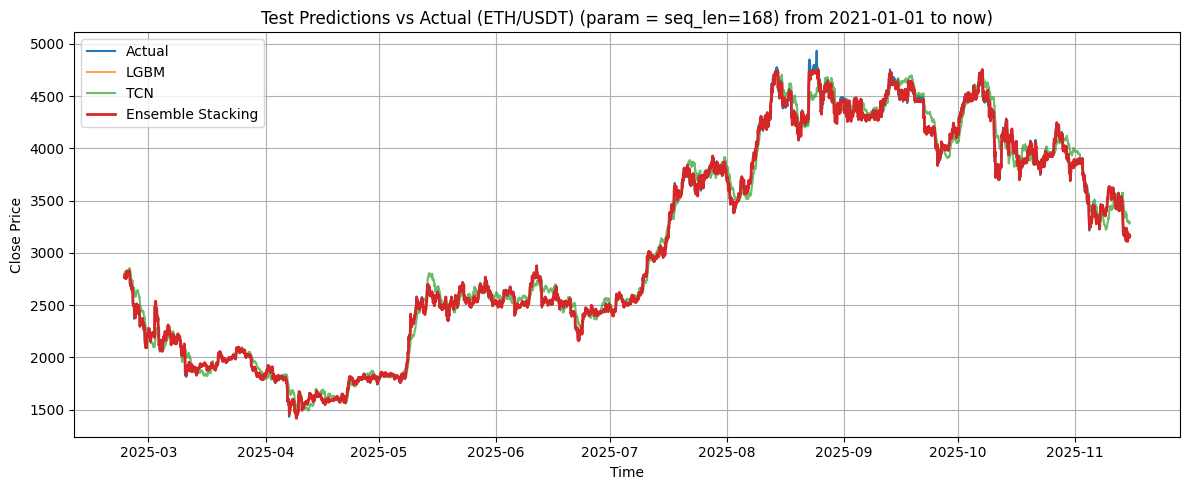

In [13]:
def collect_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
    }

results = {
    "LGBM":      collect_metrics(yte, predtest_lgb),
    "TCN":       collect_metrics(yte, predtest_tcn),
    "Mean":      collect_metrics(yte, predtest_mean),
    "W-Mean":    collect_metrics(yte, predtest_wmean),
    "Stacking":  collect_metrics(yte, predtest_stack),
}

metrics_df = pd.DataFrame(results).T
print(metrics_df)

plt.figure()
plt.plot(idx_test, yte, label="Actual")
plt.plot(idx_test, predtest_lgb, label="LGBM", alpha=0.7)
plt.plot(idx_test, predtest_tcn, label="TCN", alpha=0.7)
plt.plot(idx_test, predtest_stack, label="Ensemble Stacking", linewidth=2)
plt.title(f"Test Predictions vs Actual ({CONFIG.symbol}) (param = seq_len={CONFIG.seq_len}) from {CONFIG.start} to {CONFIG.end if CONFIG.end else 'now'})")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
metrics_df.to_csv("metrics_eth.csv", index=True)
print("Metrik tersimpan ke metrics_eth.csv")

Metrik tersimpan ke metrics_eth.csv


In [ ]:
eval_df = pd.DataFrame({
    "timestamp": idx_test,
    "y_true": yte,
    "y_lgbm": predtest_lgb,
    "y_tcn": predtest_tcn,
    "y_mean": predtest_mean,
    "y_wmean": predtest_wmean,
    "y_stack": predtest_stack,
})

eval_df.to_csv("eval_series_eth.csv", index=False)
print("eval_series_eth.csv disimpan.")


## 9. Perancangan Fungsi Forecasting Multi-Step & Multi-Horizon

In [15]:
def get_candle_hours(tf: str) -> float:
    tf = tf.strip().lower()
    if tf.endswith("h"):
        return float(tf[:-1])
    if tf.endswith("m"):
        return float(tf[:-1]) / 60.0
    if tf.endswith("d"):
        return float(tf[:-1]) * 24.0
    raise ValueError(f"Timeframe tidak dikenali: {tf}")

def forecast_next_step(df_input, seq_len, model_lgb, model_tcn, meta_model):
    X_tab_all, _, _ = make_supervised_tabular(df_input, seq_len, horizon=1)
    X_seq_all, _, _ = make_supervised_sequence(df_input, seq_len, horizon=1)

    X_tab_last = X_tab_all[-1:]
    X_seq_last = X_seq_all[-1:]

    y_lgb = model_lgb.predict(X_tab_last)
    y_tcn = model_tcn.predict(X_seq_last).reshape(-1)
    X_meta = np.column_stack([y_lgb, y_tcn])
    y_stack = meta_model.predict(X_meta)

    return {
        "pred_lgbm": float(y_lgb[0]),
        "pred_tcn": float(y_tcn[0]),
        "pred_stack": float(y_stack[0]),
    }

def forecast_multi_steps(df_input, steps, seq_len, model_lgb, model_tcn, meta_model):
    df_tmp = df_input.copy()
    preds = []
    for _ in range(int(steps)):
        out = forecast_next_step(df_tmp, seq_len, model_lgb, model_tcn, meta_model)
        y_hat = out["pred_stack"]
        preds.append(y_hat)

        next_ts = df_tmp.index[-1] + pd.Timedelta(CONFIG.timeframe)
        last_row = df_tmp.iloc[-1].copy()
        last_row["close"] = y_hat
        df_tmp.loc[next_ts] = last_row
    return preds

def forecast_hours(df_input, hours_list, seq_len, model_lgb, model_tcn, meta_model):
    tf_h = get_candle_hours(CONFIG.timeframe)
    results = {}
    for h in hours_list:
        raw_steps = h / tf_h
        steps = max(1, int(round(raw_steps)))
        preds = forecast_multi_steps(df_input, steps, seq_len, model_lgb, model_tcn, meta_model)
        results[f"{h}h"] = {
            "steps_used": steps,
            "pred_stack": float(preds[-1]),
        }
    return results


In [16]:
hours_forecast = [1, 5, 30]
forecast_results = forecast_hours(
    df,
    hours_forecast,
    CONFIG.seq_len,
    model_lgb,
    model_tcn,
    meta_model_lr
)
forecast_results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

{'1h': {'steps_used': 1, 'pred_stack': 3154.350050063505},
 '5h': {'steps_used': 5, 'pred_stack': 3153.2007904103193},
 '30h': {'steps_used': 30, 'pred_stack': 3192.075847331777}}

## 10. Penyimpanan Model untuk Deployment

In [19]:
# Simpan model untuk deployment
joblib.dump(meta_model_lr, "models/meta_stack_eth.pkl")
model_tcn.save("models/tcn_eth.h5")
# LightGBM Booster
if hasattr(model_lgb, "save_model"):
    model_lgb.save_model("models/lgb_eth.txt")
else:
    model_lgb.booster_.save_model("models/lgb_eth.txt")

print("Model tersimpan: lgb_eth.txt, tcn_eth.h5, meta_stack_eth.pkl")


Model tersimpan: lgb_eth.txt, tcn_eth.h5, meta_stack_eth.pkl
